# Antiques Watches 

<img style="float: left; width: 300px;  height : 200px" src="data/antique_watches.jpg"> 

The following dataset contains price and age of different watches. <br /> 
Goal will be to build a simple linear regression model in order to predict the price of a watch based on its age. <br /> I'm going to fit two regression models using scikit-learn and tensorflow to compare the results to each other.

## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets, linear_model as lin_model
import pandas as pd
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

## Read & Describing Data

In [2]:
df = pd.read_csv("data/antique_watches.csv", sep=";", dtype=float); 
df.describe()

,age,price
count,32.000000,32.000000
mean,144.937500,1327.156250
std,27.395476,393.134395
min,108.000000,729.000000
25%,117.000000,1053.000000
50%,140.000000,1257.500000
75%,168.500000,1560.750000
max,194.000000,2131.000000


The range of values for age and price is relatively wide and without rescaling the values it might be possible that some of our algorithm will not perform well, so the data has to be rescaled. There are a lot of techniques to do it, I will just bring the values of both columns in a range of [0,1] by applying the following formula:  <br /> 

$ x' = \frac{x-min(x)}{max(x) - min(x)} $ <br />  

where x is the variable to be rescaled.

### Rescaling Data

In [3]:
def rescaling(x):
    return(x-np.min(x)) / (np.max(x) - np.min(x))

scaled_price = np.asarray(rescaling(df.price))
scaled_age = np.asarray(rescaling(df.age))

df = pd.concat([df, pd.DataFrame({'scaled_age': scaled_age, 'scaled_price': scaled_price})], 
               axis=1)
df.describe()

,age,price,scaled_age,scaled_price
count,32.000000,32.000000,32.000000,32.000000
mean,144.937500,1327.156250,0.429506,0.426645
std,27.395476,393.134395,0.318552,0.280410
min,108.000000,729.000000,0.000000,0.000000
25%,117.000000,1053.000000,0.104651,0.231098
50%,140.000000,1257.500000,0.372093,0.376961
75%,168.500000,1560.750000,0.703488,0.593260
max,194.000000,2131.000000,1.000000,1.000000


### Plots

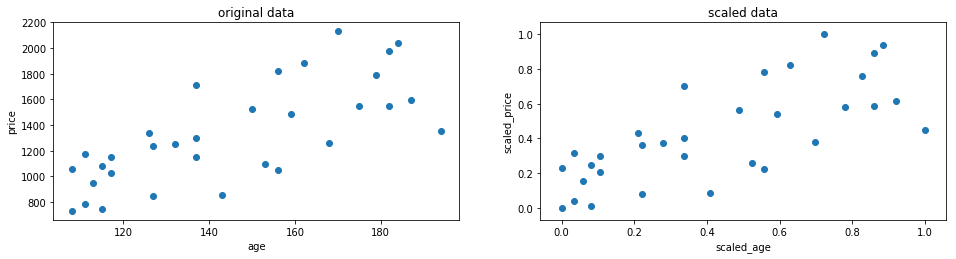

In [4]:
plt.figure(1, figsize=(16,8))

# linear
plt.subplot(221)
plt.scatter(x=df.age, y=df.price)
plt.title('original data')
plt.xlabel('age')
plt.ylabel('price')
plt.grid(False)


# scaled data
plt.subplot(222)
plt.scatter(x = df.scaled_age, y = df.scaled_price)
plt.title('scaled data')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')
plt.grid(False)

We can see on both plots that we have a sort of dependency between age and price. It seems that the older a watch is the higher the price. We can draw an imaginary straight line through the data starting somewhere on the scaled_price axis between 0.0 and 0.2 that goes diagonally upward. Let's try to fit this line using both TensorFlow and scikit-learn in python.

## TensorFlow

### Intro

A usual TensorFlow program consists of two sections:

1. Building the computational graph
2. Running the computational graph

A computational graph is a representation of a function as a network of operations and inputs, called nodes. In the following linear regression example with TensorFlow we are interested in arranging the graph in a way that a predefined loss or cost function will be minimized during our learning process. To minimize it we need to apply an algorithm that learns with a specific rate from our data and continuously adjusts the variables until it converges to a minimum. The learning rate is the size that the algorithm takes to reach the minimum. If the size is too high it is possible that we skip the optimal solution. If it’s to small we need too many iterations until the algorithm converges and it takes too long to train a model. By far the most common optimizer algorithm in deep learning is called gradient descent. At this point I can recommend a very nice lecture I've found about [optimizing a neural network](http://cs231n.github.io/optimization-1/).  <br /> 

Let's build a computational graph in TensorFlow and apply a linear regression model on our data to find out whether we can predict the watch price based on its age. 

#### Linear Regression
Let's have a look on the following equatation of a linear regression model:

$ linear\_model = W * x + b $

W and b are the variables that the algorithm wil tune for us by using gradient descent. W stands for Weights and b for bias. 

#### Loss Function:

$ loss\_function = \sum_{i=1}^n (linear\_model_i - y_i)^2$; where y is our known output

### Computational Graph

In [5]:
# Define Variables
W = tf.Variable(tf.zeros([1]))
b = tf.Variable(tf.zeros([1]))
# Define our model
linear_model = W * np.asarray(df.scaled_age) + b
# Define our loss function
loss = tf.reduce_mean(tf.square(linear_model - np.asarray(df.scaled_price)))
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)
# empy array to be feeded in our sess.run function in order to track learning rate
loss_history = np.empty(shape = [1], dtype=float)

### Initializing the variables and run the graph

In [6]:
# initializing the variables
init = tf.global_variables_initializer()

# starting the session session 
sess = tf.Session()
sess.run(init)

In [7]:
# training with 10 steps
for step in range(10):
    sess.run(train)
    loss_history = np.append(loss_history, sess.run(loss))

print("Model paramters:")
print("Weight:%f" %sess.run(W))
print("bias:%f" %sess.run(b))

Model paramters:
Weight:0.045011
bias:0.076335


### Visualizing the loss history

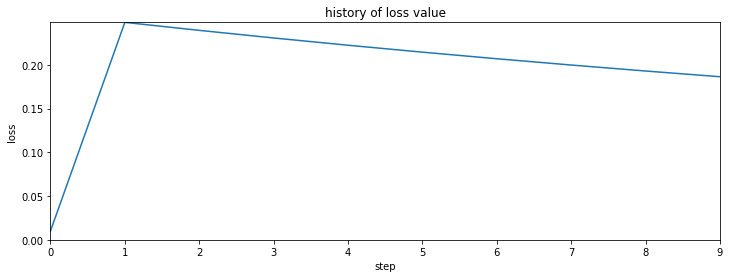

In [8]:
plt.figure(1, figsize=(12,4))
plt.plot(range(len(loss_history)),loss_history)
plt.axis([0 ,step, 0, np.max(loss_history)])
plt.title('history of loss value')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

We can see here that our loss value is descending. But after only 10 steps it doesn't seem to converge already. So we have to increase the number of steps to get more accurate model parameters. Let's try with 10000 steps:

#### Retrain our model with 10000 steps

In [9]:
loss_history = np.empty(shape = [1], dtype=float)

# initializing the variables
sess.run(init)

# training the line
for step in range(10000):
    sess.run(train)
    loss_history = np.append(loss_history, sess.run(loss))

print("Model paramters:")
print("Weight:%f" %sess.run(W))
print("bias:%f" %sess.run(b))

Model paramters:
Weight:0.642781
bias:0.150567


### Visualizing the loss history

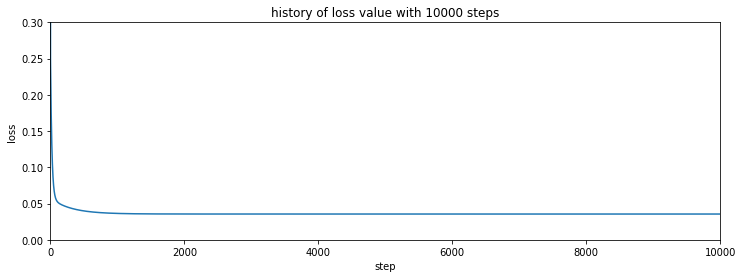

In [10]:
plt.figure(1, figsize=(12,4))
plt.plot(range(len(loss_history)),loss_history)
plt.axis([0, step, 0, np.max(loss_history)])
plt.title('history of loss value with 10000 steps')
plt.xlabel('step')
plt.ylabel('loss')
plt.ylim(0,0.3)
plt.show()

Much better. The algorithm seems to converge after a few hundred steps.

#### Final Linear Regression Equation

$linear\_model = 0.642781 * x + 0.150567$

### Model Plot

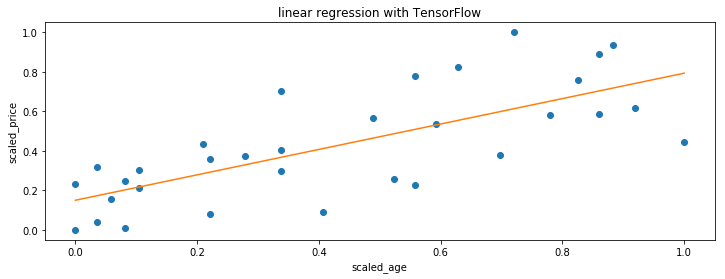

In [11]:
x_test = df.scaled_age
y_test = sess.run(W) * x_test + sess.run(b)

plt.figure(1, figsize=(12,4))
plt.plot(df.scaled_age, df.scaled_price,'o', x_test, y_test)
plt.title('linear regression with TensorFlow')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')
plt.show()

In [12]:
sess.close()

## Scikit-learn model

What I want to do in this section is to train a linear regression model with scikit-learn implemented functions in order to compare the weights and biases to see if we did everything right in TensorFlow:

### Create linear regression object and train model

In [14]:
# Create linear regression object
regr = lin_model.LinearRegression()
x_train = df.scaled_age.values.reshape(-1,1)
y_train = df.scaled_price.values.reshape(-1,1)
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Results

In [15]:
# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [[ 0.64279755]]
Intercept: 
 [ 0.15055969]


#### Final Linear Regression Equation

Very similar Values (Coefficiants = Weights; Intercept = bias)!

$linear\_model = 0.64279755 * x + 0.15055969$

### Model Plot

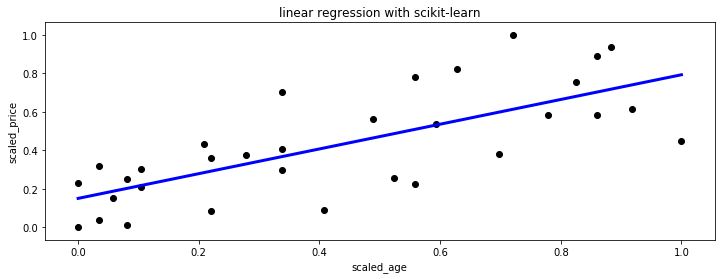

In [16]:
# Plot outputs
plt.figure(1, figsize=(12,4))
plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, regr.predict(x_train), color='blue',linewidth=3)
plt.title('linear regression with scikit-learn')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')
plt.show()

## Summary

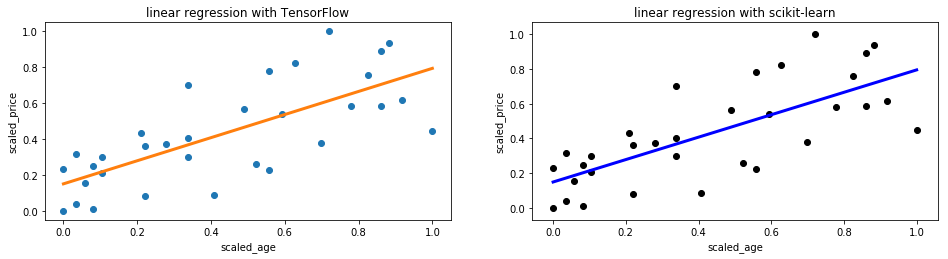

In [17]:
plt.figure(1, figsize=(16,8))

# TensorFlow
plt.subplot(221)
plt.figure(1, figsize=(12,4))
plt.plot(df.scaled_age, df.scaled_price,'o', x_test, y_test, linewidth=3)
plt.title('linear regression with TensorFlow')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')


# scikit-learn
plt.subplot(222)
plt.figure(1, figsize=(12,4))
plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, regr.predict(x_train), color='blue',linewidth=3)
plt.title('linear regression with scikit-learn')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')

|                      | TensorFlow | scikit-learn linear regression |
|----------------------|------------|--------------------------------|
| Weight (Coefficient) |  0.642781  |           0.64279755           |
| bias (Intercept)     |  0.150567  |           0.15055969           |